# Trabajo Práctico - Organización de Datos
## Parte 1 - Análisis de datos
- Continanza, Nicolás (97576)
- De Angelis Riva, Lukas Nahuel  (103784)

#### FIUFIP: Que No Se Escape Nadie (?)

A partir de la información recolectada por FIUFIP, queremos hacer un análisis que nos permita inferir qué ciudadanos tienen un alto poder adquisitivo. Para esto, y tomando en cuenta la información con la que contamos y sus limitaciones, creemos que será valioso poder responder las siguientes preguntas, y evaluar si nos aportan información útil:

1. ¿Cuántas personas tienen un alto poder adquisitivo en los datos recolectados por la agencia?
2. ¿Hay alguna relación entre la edad de las personas encuestadas y su poder adquisitivo?
3. ¿Existe un cambio notable en la respuesta a la pregunta anterior si separamos la muestra por género?
4. Respondiendo las tres preguntas anteriores podríamos encontrar una relación entre las variables edad y género, y sería interesante saber qué tan similar o disímil es la variable edad entre los tipos de trabajo que realizan. Entonces, ¿Cómo se distribuye la edad de las personas encuestadas según su trabajo?
6. ¿Qué se puede decir sobre los tipos de sala más elegidos separando a los encuestados por edad?
7.
8.

## Imports y puesta en escena

In [6]:
import pandas as pd
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import pyplot as plt
import matplotlib

import numpy as np

GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)
TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))

Para empezar, utilizamos la función feature_engineering a la que llegamos en `haciendoUnPocoDeIngenieria.ipynb` tras analizar las características del dataset.

In [7]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    
    return data_set_mejorado

In [8]:
df = feature_engineering(df)

# Información previa

Del Notebook anterior nos llevamos la información de que la mejor primera estimación sobre el valor adquisitivo de las personas están dados por los atributos de bolsa y anios_estudiados

# Condicionando por bolsa

Tendremos entonces 3 data sets diferentes, la gente que ganó, la gente que perdió y la gente con neto 0.

In [57]:
def determinar_categoria_en_bolsa(accion_en_bolsa):
    if(accion_en_bolsa > 0):
        return 'Ganancia'
    elif(accion_en_bolsa < 0):
        return 'Pérdida'
    else:
        return 'Nada'

df_bolsa = df.copy()
df_bolsa['bolsa'] = df_bolsa['ganancia_perdida_declarada_bolsa_argentina'].apply(determinar_categoria_en_bolsa)
del df_bolsa['ganancia_perdida_declarada_bolsa_argentina']

df_ganancia = df[df['ganancia_perdida_declarada_bolsa_argentina'] > 0].copy().reset_index()
df_perdida = df[df['ganancia_perdida_declarada_bolsa_argentina'] < 0].copy().reset_index()
df_nada = df[df['ganancia_perdida_declarada_bolsa_argentina'] == 0].copy().reset_index()

De ahora en más los gráficos y decisiones que tomemos serán en base a si tuvo ganancia, pérdida o si no accionó en la bolsa.

### Edad

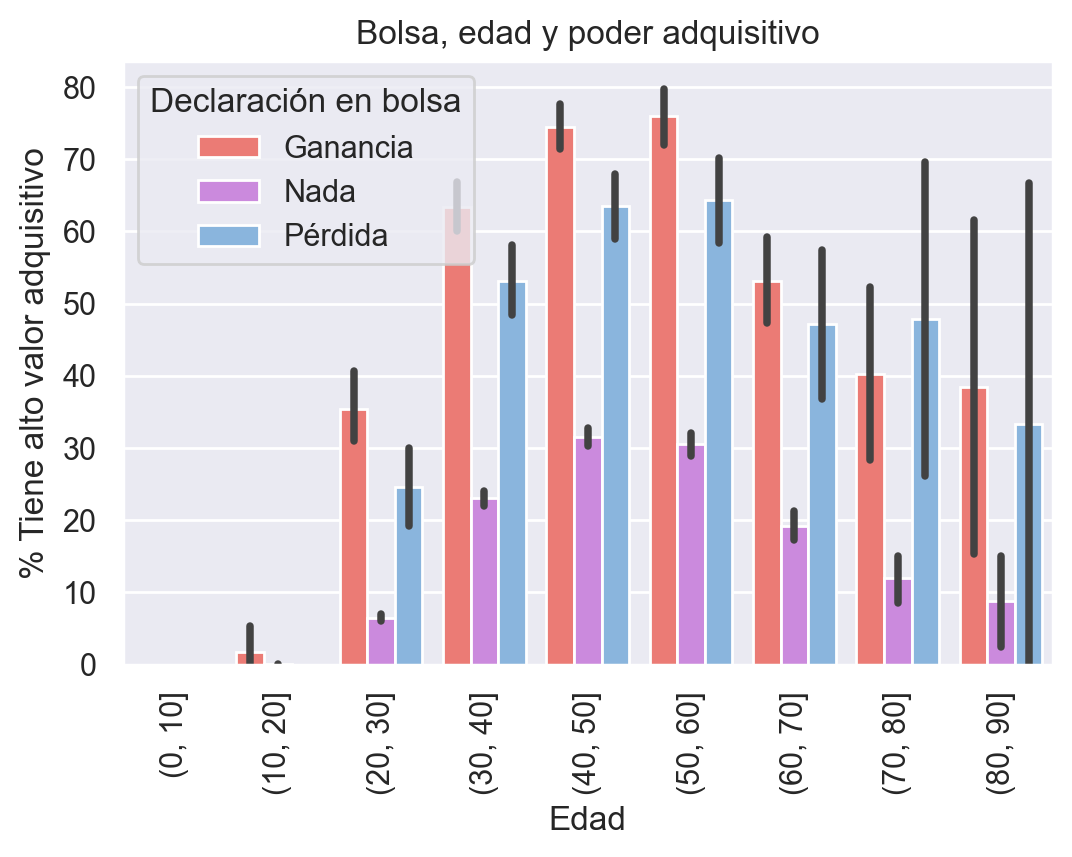

In [6]:
df_tmp = df_bolsa.copy()

df_tmp['bins'] = pd.cut(df_tmp.edad, range(0, int(df_tmp['edad'].max()) + 10,10))
# Configuro el grafico, armo el countplot y setteo labels varios
plt.figure(dpi=200)
sns.barplot(
    data=df_tmp,
    x='bins',
    y='tiene_alto_valor_adquisitivo',
    hue='bolsa',
    palette=['#FF6961', '#D37CEB', '#7CB6EB'],
    estimator=lambda x: np.mean(x)*100.0)

#sns.barplot(x="bins", hue="bolsa", y="tiene_alto_valor_adquisitivo", data=df_tmp)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Edad")
plt.xticks(rotation=90)
plt.title('Bolsa, edad y poder adquisitivo')
plt.legend(title='Declaración en bolsa')
plt.show()


Es notable observar que la gente que invierte en bolsa (ganancia o pérdida) obtiene un boost interesante en edades intermedias (entre 30 y 70 años) provocando que la proporción de gente con alto poder adquisitivo en estas etapas siga siendo notable.

Veamos ahora si esto incrementa nuestro accuracy

In [131]:
def por_edad_y_bolsa(row):
    if(row['bolsa'] == 'Nada'):
        return 0
    elif(row['edad'] > 30 and row['edad'] < 70):
        return 1
    else:
        return 0
indice = np.mean(df['tiene_alto_valor_adquisitivo'] == df_bolsa.apply(func=por_edad_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 79.1%


El porcentaje de aciertos aumenta, pero prácticamente nada, esto es debido a que no pudimos filtrar correctamente la gente con poder adquisitivo alto que cayó en "Nada". Que son muchos más.

### Años estudiados

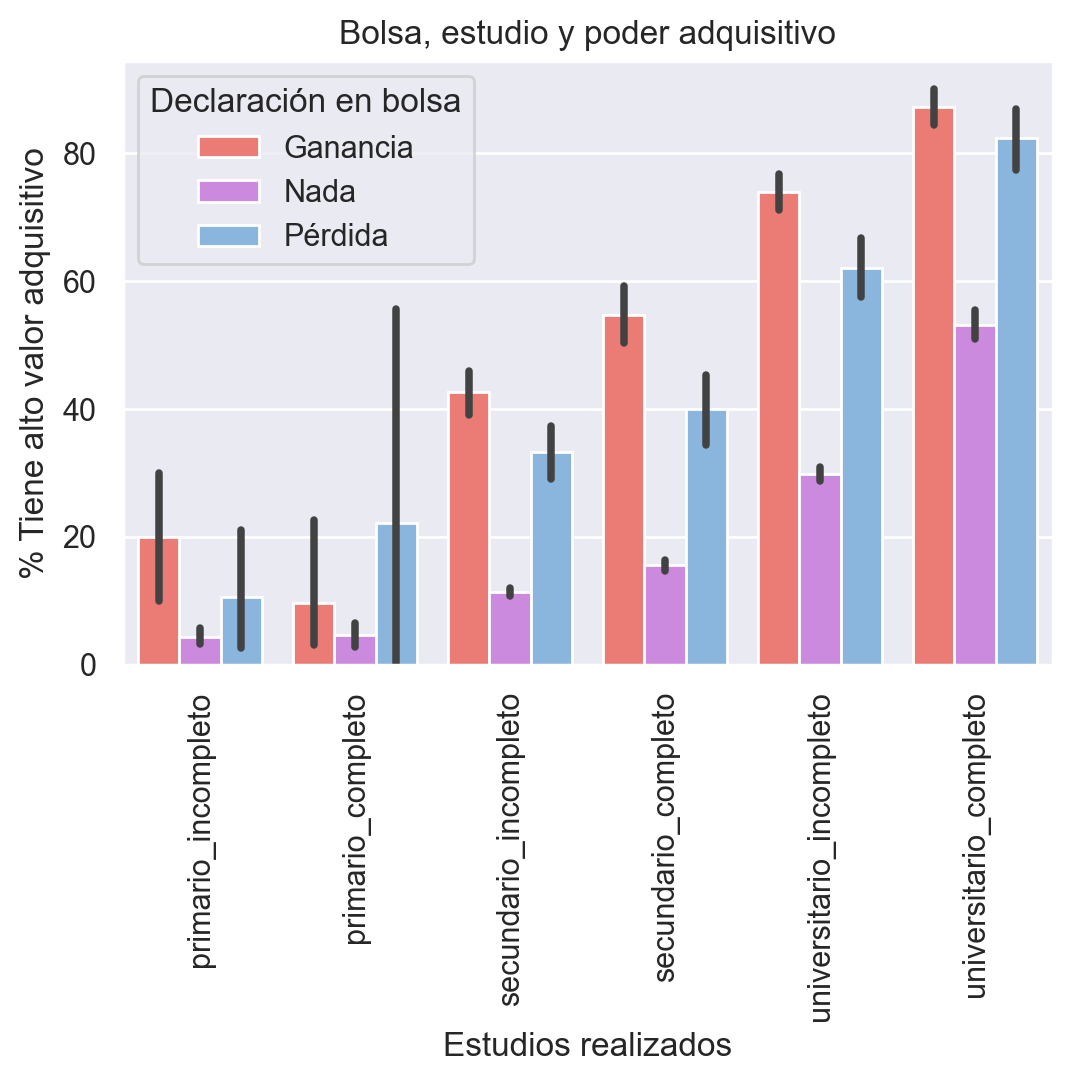

In [20]:
def categorizar_por_educacion(anios_estudiados):
    if(anios_estudiados <= 1):
        return 'prescolar'
    elif(anios_estudiados <= 9):
        if(anios_estudiados == 9):
            return 'primario_completo'
        return 'primario_incompleto'
    elif(anios_estudiados <= 14):
        if(anios_estudiados== 14):
            return 'secundario_completo'
        return 'secundario_incompleto'
    elif(anios_estudiados <= 17):
        return 'universitario_incompleto'
    return 'universitario_completo'

df_tmp = df_bolsa.copy()
df_tmp['educacion'] = df_tmp['anios_estudiados'].apply(categorizar_por_educacion)
del df_tmp['anios_estudiados']

# Configuro el grafico, armo el countplot y setteo labels varios
plt.figure(dpi=200)
sns.barplot(
    data=df_tmp,
    x='educacion',
    y='tiene_alto_valor_adquisitivo',
    hue='bolsa',
    palette=['#FF6961', '#D37CEB', '#7CB6EB'],
    estimator=lambda x: np.mean(x)*100.0,
    order=['primario_incompleto', 'primario_completo', 'secundario_incompleto', 'secundario_completo', 'universitario_incompleto', 'universitario_completo']
)

#sns.barplot(x="bins", hue="bolsa", y="tiene_alto_valor_adquisitivo", data=df_tmp)

plt.ylabel("% Tiene alto valor adquisitivo")
plt.xlabel("Estudios realizados")
plt.xticks(rotation=90)
plt.title('Bolsa, estudio y poder adquisitivo')
plt.legend(title='Declaración en bolsa')
plt.show()


In [132]:
def por_educacion_y_bolsa(row):
    if(row['bolsa'] == 'Nada'):
        if(row['anios_estudiados'] >= 18):
            return 1
        else:
            return 0
    elif(row['bolsa'] == 'Pérdida'):
        if(row['anios_estudiados'] >= 15):
            return 1
        else:
            return 0
    else: #row['bolsa'] == 'Ganancia'
        if(row['anios_estudiados'] >= 14):
            return 1
        else:
            return 0
indice = np.mean(df['tiene_alto_valor_adquisitivo'] == df_bolsa.apply(func=por_educacion_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 79.7%


Nuevamente nos encontramos en el mismo problema, no logramos encontrar una condición que logre atrapar la mayor parte de la gente que no realizó inversión en la bolsa.

Veamos si esto es cierto, para lo cual filtraré sólo la gente que tiene ganancia/pérdida en bolsa y veré si me es suficiente el índice de acierto:

In [133]:
df_tmp = df_bolsa[df_bolsa['bolsa'] != 'Nada'].copy()
indice = np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == df_tmp.apply(func=por_educacion_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 68.1%


In [134]:
df_tmp = df_bolsa[df_bolsa['bolsa'] == 'Nada'].copy()
indice = np.mean(df_tmp['tiene_alto_valor_adquisitivo'] == df_tmp.apply(func=por_educacion_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 81.4%


Por lo que mi hipótesis está errada.
Se tiene que hacer un tratamiento especial sobre las personas con declaración en la bolsa para aumentar el índice porcentual a más que 68%
O
Realizar un tratamiento más intensivo sobre la gente sin declaración en bolsa y aumentar su valor (que al ser muchísimos más está ponderado y aumentar un 2% su valor aumentará casi un 2% en el índice total)

### Rol familiar registrado, categoría de trabajo y bolsa

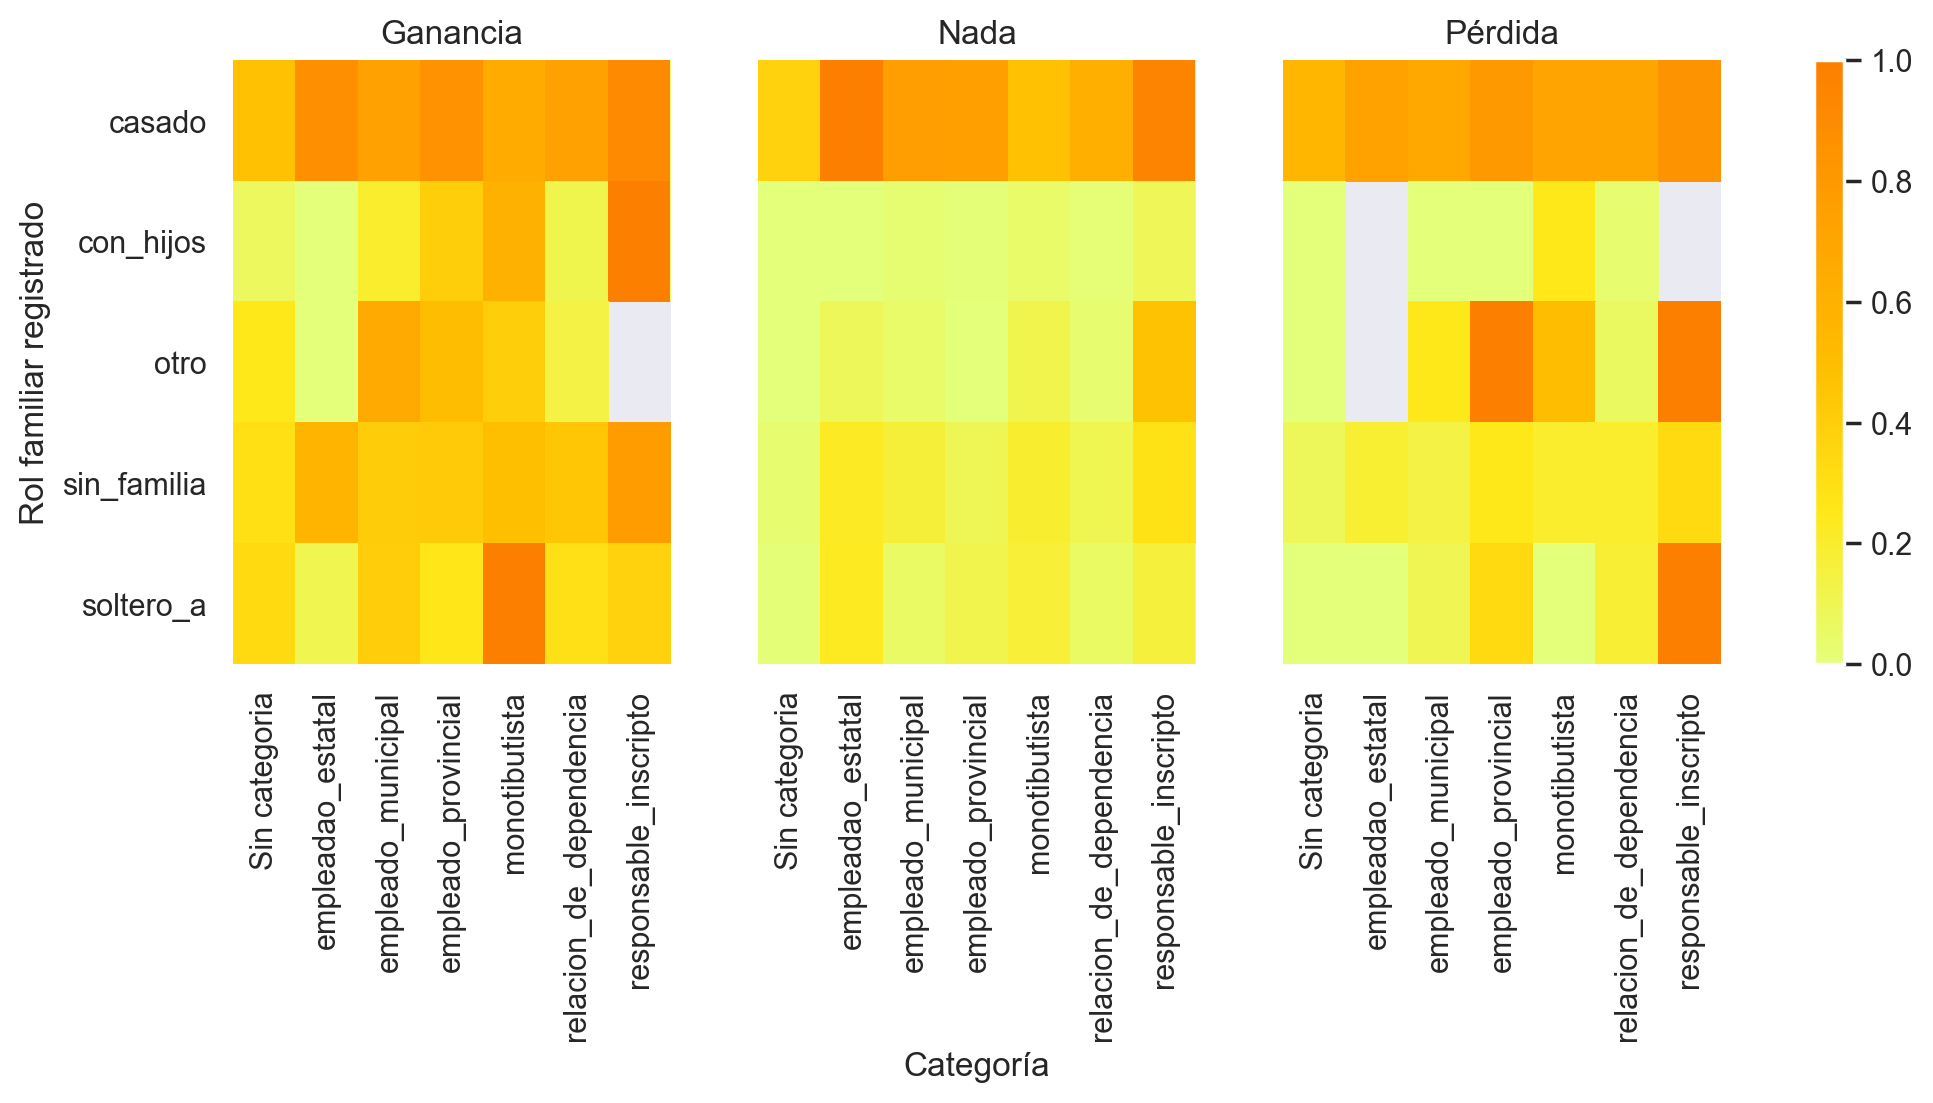

In [127]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4))
fig.set_dpi(200)

#First
cooccurrence_g = pd.pivot_table(
    df_ganancia,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
im = sns.heatmap(cooccurrence_g, ax=ax1, cmap='Wistia', cbar = False)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('Ganancia')

#Second
cooccurrence_n = pd.pivot_table(
    df_nada,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
sns.heatmap(cooccurrence_n, ax=ax2, cmap='Wistia', cbar = False)
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax2.set_title('Nada')

#Third

cooccurrence_p = pd.pivot_table(
    df_perdida,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
sns.heatmap(cooccurrence_p, ax=ax3, cmap='Wistia', cbar = False)
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax3.set_title('Pérdida')

#

ax1.set_ylabel("Rol familiar registrado")
ax2.set_xlabel("Categoría")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'vertical')
plt.show()

In [138]:
def por_educacion_y_bolsa(row):
    if(row['bolsa'] == 'Nada'):
        if(row['anios_estudiados'] >= 18):
            return 1
        else:
            if(row['rol_familiar_registrado'] == 'casado'):
                return 1
            return 0
    elif(row['bolsa'] == 'Pérdida'):
        if(row['anios_estudiados'] >= 15):
            return 1
        else:
            return 0
    else: #row['bolsa'] == 'Ganancia'
        if(row['anios_estudiados'] >= 14):
            return 1
        else:
            return 0
indice = np.mean(df['tiene_alto_valor_adquisitivo'] == df_bolsa.apply(func=por_educacion_y_bolsa, axis=1))
print(f"Aciertos: {round(100.0*indice, 1)}%")

Aciertos: 69.7%


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 4))
fig.set_dpi(200)

#First
cooccurrence_g = pd.pivot_table(
    df_ganancia,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
im = sns.heatmap(cooccurrence_g, ax=ax1, cmap='Wistia', cbar = False)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('Ganancia')

#Second
cooccurrence_n = pd.pivot_table(
    df_nada,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
sns.heatmap(cooccurrence_n, ax=ax2, cmap='Wistia', cbar = False)
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax2.set_title('Nada')

#Third

cooccurrence_p = pd.pivot_table(
    df_perdida,
    'tiene_alto_valor_adquisitivo',
    'rol_familiar_registrado',
    'categoria_de_trabajo',
    'mean'
)
sns.heatmap(cooccurrence_p, ax=ax3, cmap='Wistia', cbar = False)
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax3.set_title('Pérdida')

#

ax1.set_ylabel("Rol familiar registrado")
ax2.set_xlabel("Categoría")

mappable = im.get_children()[0]
plt.colorbar(mappable, ax = [ax1,ax2,ax3],orientation = 'vertical')
plt.show()

---

In [150]:
df.corr()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
anios_estudiados,1.000000,0.030915,0.114807,0.144805,0.328472
edad,0.030915,1.000000,0.074261,0.068474,0.233931
ganancia_perdida_declarada_bolsa_argentina,0.114807,0.074261,1.000000,0.075197,0.214419
horas_trabajo_registradas,0.144805,0.068474,0.075197,1.000000,0.229634
tiene_alto_valor_adquisitivo,0.328472,0.233931,0.214419,0.229634,1.000000


In [152]:
df

,anios_estudiados,barrio,categoria_de_trabajo,edad,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,matrimonio_civil,0,mujer,40,judaismo,casado,0,profesional_especializado
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,Palermo,relacion_de_dependencia,27,matrimonio_civil,0,mujer,38,cristianismo,casado,0,soporte_tecnico
32557,13,Palermo,relacion_de_dependencia,40,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector
32558,13,Palermo,relacion_de_dependencia,58,viudo_a,0,mujer,40,cristianismo,soltero_a,0,entretenimiento
32559,13,Palermo,relacion_de_dependencia,22,sin_matrimonio,0,hombre,20,cristianismo,con_hijos,0,entretenimiento


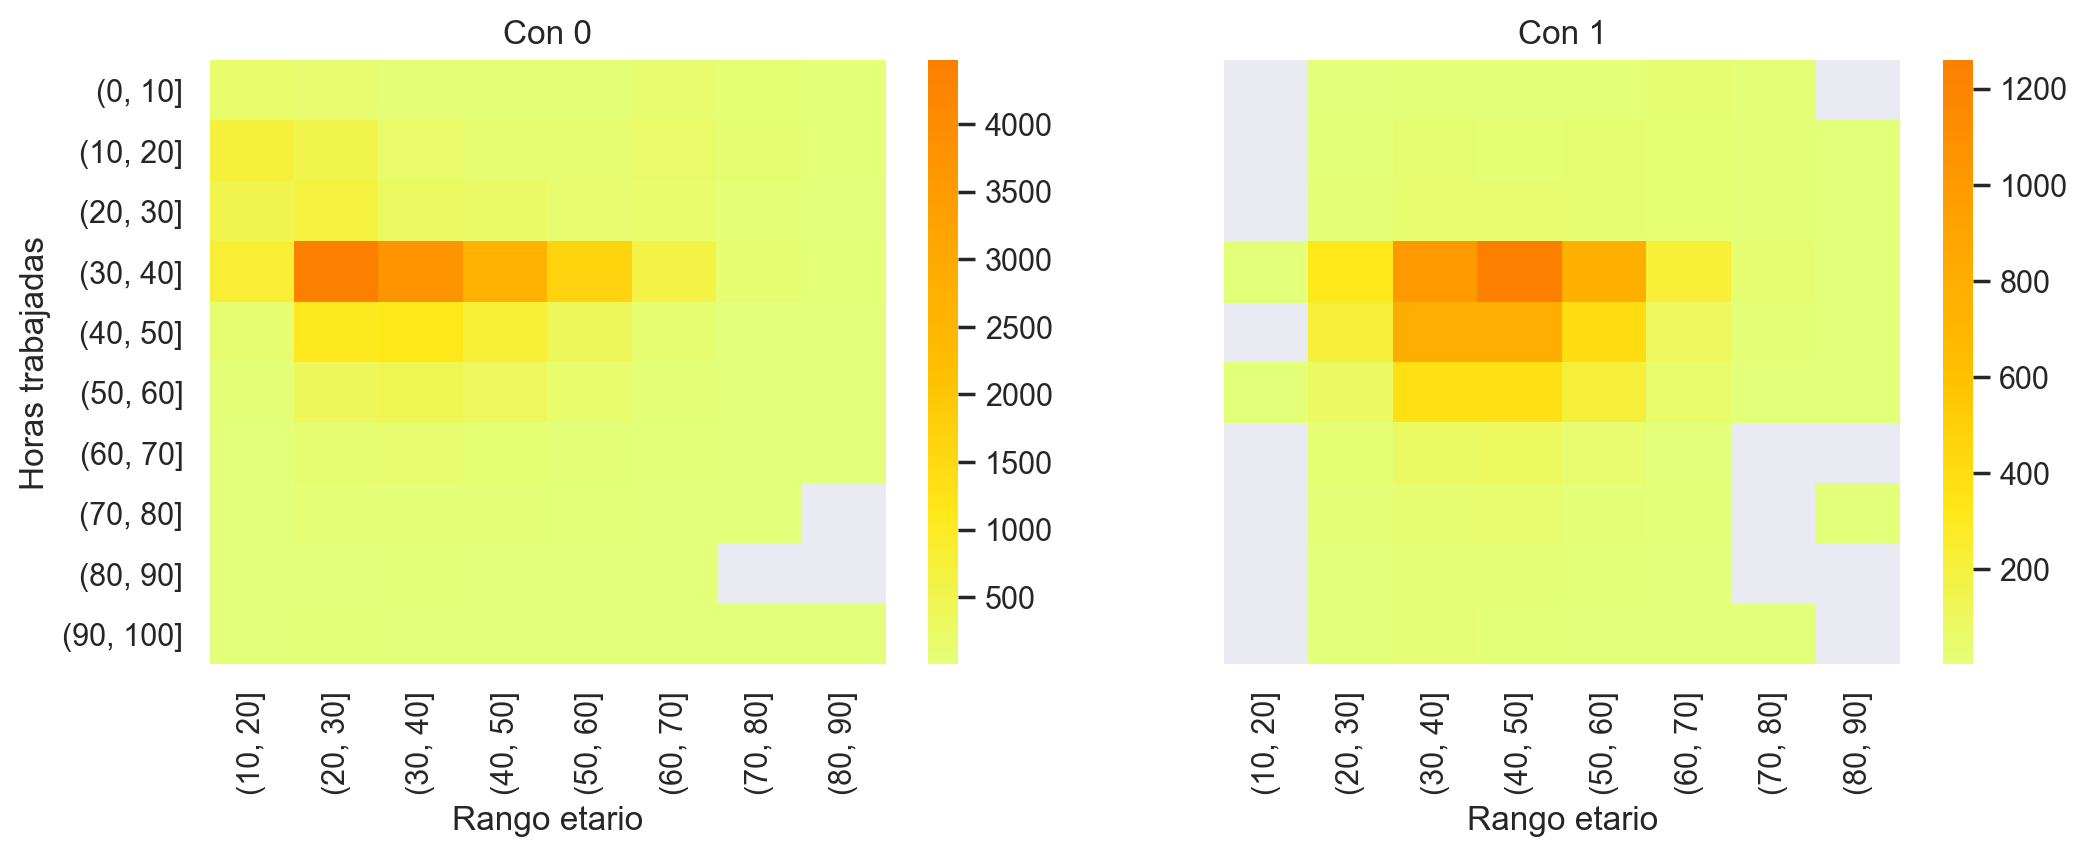

In [160]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 4), )
fig.set_dpi(200)

df_tmp = df.copy()
df_tmp['bins_edades'] = pd.cut(df['edad'], range(0, int(df['edad'].max()) + 10,10))
df_tmp['bins_horas_trabajadas'] = pd.cut(df['horas_trabajo_registradas'], range(0, int(df['horas_trabajo_registradas'].max()) + 10,10))

#First
cooccurrence_g = pd.pivot_table(
    df_tmp[df_tmp['tiene_alto_valor_adquisitivo'] == 0],
    'tiene_alto_valor_adquisitivo',
    'bins_horas_trabajadas',
    'bins_edades',
    'count'
)
im = sns.heatmap(cooccurrence_g, ax=ax1, cmap='Wistia', cbar = True)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.set_title('Con 0')

#Second
cooccurrence_n = pd.pivot_table(
    df_tmp[df_tmp['tiene_alto_valor_adquisitivo'] == 1],
    'tiene_alto_valor_adquisitivo',
    'bins_horas_trabajadas',
    'bins_edades',
    'count'
)

ax1.get_shared_y_axes().join(ax2)
sns.heatmap(cooccurrence_n, ax=ax2, cmap='Wistia', cbar = True)
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax2.set_title('Con 1')
#

ax1.set_ylabel("Horas trabajadas")
ax1.set_xlabel("Rango etario")
ax2.set_xlabel("Rango etario")

mappable = im.get_children()[0]
plt.show()

Text(0.5, 0, 'X1')

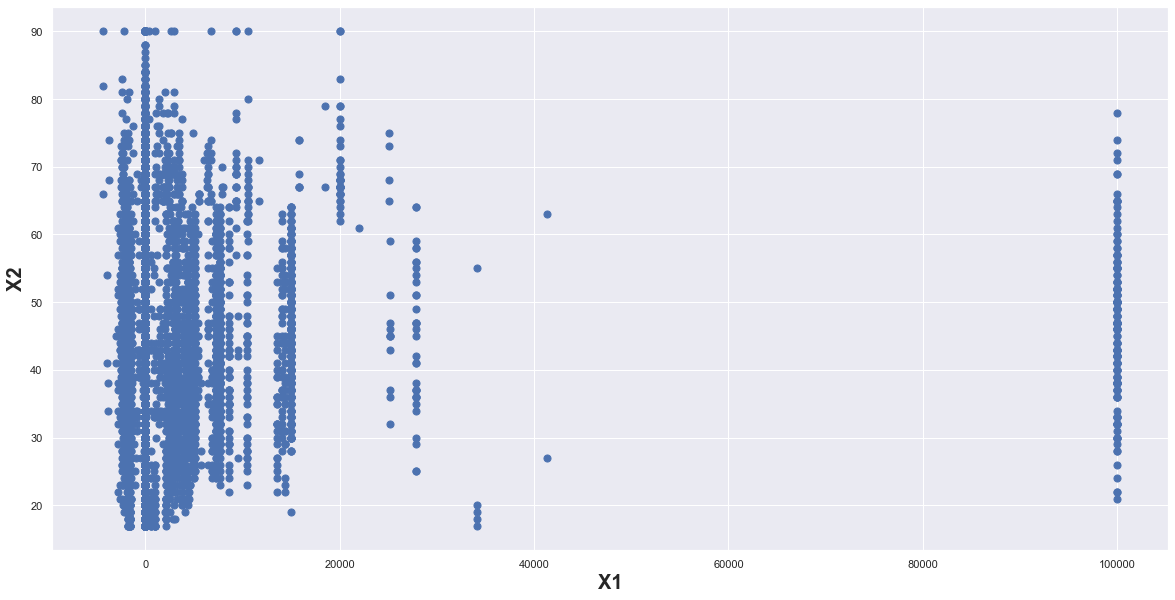

In [35]:
horas = list(df['ganancia_perdida_declarada_bolsa_argentina'])
edad = list(df['edad'])
X = np.column_stack((horas, edad))

plt.figure(figsize=(20, 10))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.ylabel("X2", fontsize=20, weight="bold")
plt.xlabel("X1", fontsize=20, weight="bold")

In [39]:
df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,anios_estudiados,barrio,categoria_de_trabajo,edad,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
anios_estudiados,1.000000,0.064278,0.010825,0.044220,0.008624,0.008791,0.000754,0.046682,0.029725,0.042404,-0.046125,0.074657
barrio,0.064278,1.000000,-0.009439,-0.008626,0.002577,0.004126,0.007812,-0.004607,0.219709,0.043497,-0.028092,0.020639
categoria_de_trabajo,0.010825,-0.009439,1.000000,0.071130,0.036559,0.026796,0.019490,0.029862,0.009279,0.011641,0.047878,0.215787
edad,0.044220,-0.008626,0.071130,1.000000,0.097790,0.057409,0.013372,0.080569,-0.013825,-0.019727,-0.044484,0.061406
estado_marital,0.008624,0.002577,0.036559,0.097790,1.000000,0.054288,0.181882,0.028875,0.012729,0.048984,0.002581,0.006737
ganancia_perdida_declarada_bolsa_argentina,0.008791,0.004126,0.026796,0.057409,0.054288,1.000000,-0.008638,0.014335,-0.013488,-0.013722,0.096846,-0.009939
genero,0.000754,0.007812,0.019490,0.013372,0.181882,-0.008638,1.000000,0.055512,0.067808,0.176299,-0.216021,-0.147810
horas_trabajo_registradas,0.046682,-0.004607,0.029862,0.080569,0.028875,0.014335,0.055512,1.000000,-0.020418,0.013930,-0.026722,0.039353
religion,0.029725,0.219709,0.009279,-0.013825,0.012729,-0.013488,0.067808,-0.020418,1.000000,0.091991,-0.067707,0.016552
rol_familiar_registrado,0.042404,0.043497,0.011641,-0.019727,0.048984,-0.013722,0.176299,0.013930,0.091991,1.000000,-0.127452,-0.003187


In [40]:
from sklearn import metrics

roc_auc_score()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000e+00,6.804621e+05,1.738598e+05,6.039304e+05,4.173921e+05,4.356455e+05,616055.0,5.162471e+05,6.828053e+05,3.518886e+05,668161.0,1.753301e+05
1,3.538727e+05,0.000000e+00,2.802602e+05,7.387828e+05,5.031400e+05,5.349308e+05,653803.5,6.712377e+05,5.652671e+05,4.252775e+05,725870.0,3.039282e+05
2,9.466550e+04,2.297743e+05,0.000000e+00,6.209658e+05,9.905320e+04,2.303187e+05,165530.5,2.684119e+05,1.955261e+05,8.334563e+04,176740.5,8.446546e+04
3,9.583555e+06,2.392024e+07,7.840623e+06,0.000000e+00,1.461411e+07,1.066686e+07,21301963.0,1.247885e+07,2.368932e+07,1.428201e+07,22709045.5,6.726847e+06
4,8.441144e+04,1.111378e+05,3.748891e+04,6.806257e+05,0.000000e+00,2.181891e+05,52286.0,2.412153e+05,7.844573e+04,5.001140e+04,77996.5,1.096426e+05
5,7.334965e+06,1.741201e+07,6.145381e+06,2.044028e+06,1.000370e+07,0.000000e+00,15235505.5,9.520301e+06,1.738665e+07,1.062410e+07,15867864.0,5.859922e+06
6,8.360824e+04,4.315167e+04,4.336059e+04,7.173078e+05,2.164228e+04,2.111618e+05,0.0,2.238820e+05,1.172993e+04,2.195187e+04,12921.0,1.207569e+05
7,2.418043e+06,6.405680e+06,2.161813e+06,9.119971e+05,4.127561e+06,3.043550e+06,5552257.5,0.000000e+00,6.410662e+06,3.726451e+06,6216880.0,1.721830e+06
8,8.920441e+04,4.115200e+04,4.929554e+04,7.242295e+05,2.675391e+04,2.165280e+05,13882.0,2.316305e+05,0.000000e+00,2.599195e+04,16079.0,1.235546e+05
9,7.550415e+04,1.009771e+05,3.029423e+04,6.726747e+05,4.555569e+04,2.123744e+05,50716.5,2.362444e+05,6.807357e+04,0.000000e+00,73301.0,1.026848e+05


In [30]:
horas

[40,
 13,
 40,
 40,
 40,
 40,
 16,
 45,
 50,
 40,
 80,
 40,
 30,
 50,
 40,
 45,
 35,
 40,
 50,
 45,
 60,
 20,
 40,
 40,
 40,
 40,
 40,
 60,
 80,
 40,
 52,
 44,
 40,
 40,
 15,
 40,
 40,
 25,
 38,
 40,
 43,
 40,
 50,
 40,
 35,
 40,
 38,
 40,
 40,
 43,
 40,
 30,
 60,
 55,
 60,
 40,
 40,
 40,
 48,
 40,
 40,
 40,
 40,
 45,
 58,
 40,
 40,
 40,
 50,
 40,
 32,
 40,
 70,
 40,
 20,
 40,
 40,
 2,
 22,
 40,
 30,
 40,
 40,
 48,
 40,
 35,
 40,
 50,
 40,
 50,
 40,
 40,
 25,
 35,
 40,
 50,
 60,
 48,
 40,
 40,
 40,
 60,
 50,
 40,
 40,
 40,
 32,
 40,
 40,
 40,
 40,
 40,
 50,
 25,
 40,
 50,
 50,
 40,
 56,
 41,
 40,
 60,
 40,
 50,
 35,
 40,
 28,
 40,
 40,
 40,
 60,
 40,
 35,
 50,
 36,
 40,
 60,
 35,
 20,
 40,
 40,
 40,
 30,
 40,
 40,
 30,
 24,
 24,
 40,
 40,
 38,
 40,
 40,
 35,
 45,
 46,
 40,
 2,
 60,
 50,
 20,
 40,
 40,
 40,
 40,
 40,
 42,
 40,
 16,
 20,
 40,
 40,
 40,
 50,
 40,
 25,
 40,
 40,
 12,
 65,
 38,
 40,
 45,
 40,
 42,
 40,
 40,
 50,
 50,
 1,
 28,
 40,
 40,
 45,
 24,
 40,
 40,
 55,
 40,
 40,
 40

array([[40, 39],
       [13, 50],
       [40, 38],
       ...,
       [40, 58],
       [20, 22],
       [40, 52]])

In [41]:
from functools import lru_cache

In [42]:
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

In [61]:
def feature_engineering(df):
    # Missings en barrio
    data_set_mejorado = df.copy()
    barrios = df['barrio'].dropna()
    cantidad = df['barrio'].isna().value_counts()[True]
    muestra = barrios.sample(cantidad)
    it = iter(muestra)
    data_set_mejorado['barrio'] = data_set_mejorado['barrio'].apply(lambda x: next(it) if str(x) == 'nan' else x)

    # Missings en categoría de trabajo
    data_set_mejorado['categoria_de_trabajo'] = data_set_mejorado['categoria_de_trabajo'].apply(lambda x: 'Sin categoria' if str(x) == 'nan' else x)

    # Missings en trabajo
    data_set_mejorado['trabajo'] = data_set_mejorado['trabajo'].apply(lambda x: 'No responde' if str(x) == 'nan' else x)

    # Eliminación de categoría "sin trabajo"
    data_set_mejorado = data_set_mejorado[data_set_mejorado.categoria_de_trabajo != 'sin_trabajo']

    # Eliminación de el atributo eduación alcanzada
    del data_set_mejorado['educacion_alcanzada']

    # Juntamos casado y casada en una misma categoría.
    data_set_mejorado['rol_familiar_registrado'] = data_set_mejorado['rol_familiar_registrado'].apply(lambda x : 'casado' if x == 'casada' else x)
    data_set_mejorado = data_set_mejorado[['edad', 'ganancia_perdida_declarada_bolsa_argentina', 'horas_trabajo_registradas', 'tiene_alto_valor_adquisitivo']]
    data_set_mejorado = pd.get_dummies(data_set_mejorado, drop_first=True, columns=['edad', 'ganancia_perdida_declarada_bolsa_argentina'])

    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(data_set_mejorado.tiene_alto_valor_adquisitivo)
    X = data_set_mejorado.drop(columns=['tiene_alto_valor_adquisitivo'])
    y = label_encoder.transform(data_set_mejorado.tiene_alto_valor_adquisitivo)

    return X, y, data_set_mejorado, label_encoder

In [53]:
def get_data():
    GSPREADHSEET_DOWNLOAD_URL = (
        "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
    )
    TP_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
    df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=TP_GID))
    return df

In [66]:
def get_tree(X, y, max_depth=5, min_samples_leaf=10):
    """Devuelve un árbol entrenado."""
    clf = tree.DecisionTreeClassifier(
        random_state=117, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    clf.fit(X, y)
    return clf


def plot_tree(max_depth, min_samples_leaf):
    """Interfaz interactiva para visualizar un árbol entrenado."""
    df = get_data()
    X, y, df, y_encoder = feature_engineering(df)
    clf = get_tree(X, y, max_depth, min_samples_leaf)

    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X.columns,
        class_names=list(y_encoder.classes_),
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))

df = get_data()
X, y, a, y_encoder = feature_engineering(df)
clf = get_tree(X, y, IntSlider(min=1, max=15), IntSlider(min=1, max=25, value=10))
clf

#inter = interactive(
#    plot_tree,
#    max_depth=IntSlider(min=1, max=15),
#    min_samples_leaf=IntSlider(min=1, max=25, value=10),
#)
#display(inter)

TypeError: '<' not supported between instances of 'float' and 'IntSlider'